# Exam - Solutions
## Data Analysis
### FINM August Review 

Mark Hendricks

hendricks@uchicago.edu

Maneet Singh - TA

maneetsingh@uchicago.edu

### Data

#### For Part 1 and Part 2:

This assignment uses data from Yahoo Finance (See the ”Demo Regression” file). Use one of the following methods to extract the required data:

- yfinance: https://pypi.org/project/yfinance/
- pandas-datareader: https://pandas-datareader.readthedocs.io/en/latest/


#### For Part 3 and Part 4:

- This homework uses the file, “treasury_rates.xls”.
- Find the data in the Github repo associated with the module, (link on Canvas.)
- The data file contains Daily treasury rates, $y^{T}_t$, for different tenors $T = \{1yr, 2yr, 5yr, 10yr, 30yr\}$

## 1  Data and Constructing Returns

1. Acquire daily adjusted close prices for GOLD, SPY, and TSLA, use the time periods where we have data for all.


2. Construct daily returns for GOLD, SPY and TSLA (use the percent change pandas method).

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from arch import arch_model
from arch.univariate import GARCH, EWMAVariance

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.2, rc={'figure.figsize':(12,8)})
import warnings
warnings.filterwarnings('ignore')

###### 1.

In [2]:
data = yf.download('GOLD SPY TSLA')['Adj Close'].dropna()

[*********************100%***********************]  3 of 3 completed


In [3]:
display(data.head())

,GOLD,SPY,TSLA
Date,,,
2010-06-29,37.463127,82.774994,1.592667
2010-06-30,37.804447,81.988640,1.588667
2010-07-01,35.881351,81.623222,1.464000
2010-07-02,35.997902,81.178436,1.280000
2010-07-06,35.781445,81.710625,1.074000


###### 2.

In [4]:
rets = data.pct_change().dropna()
display(rets.head())

,GOLD,SPY,TSLA
Date,,,
2010-06-30,0.009111,-0.009500,-0.002511
2010-07-01,-0.050870,-0.004457,-0.078473
2010-07-02,0.003248,-0.005449,-0.125683
2010-07-06,-0.006013,0.006556,-0.160937
2010-07-07,0.020940,0.031496,-0.019243


## 2 Linear Regression

1. Regress GOLD on the market (SPY) and report $\alpha$, $\beta$, and $R^2$


2. If SPY were to decrease by 5% tomorrow, what would happen to GOLD and how certain of the movement in GOLD would you be?


3. Regress GOLD on the market without an intercept and report $\beta$ and $R^2$


4. How does no longer including an intercept change the role of the regressor? In 2.1 what is the conceptual meaning of $\alpha$?

###### 1.

In [5]:
y = rets[['GOLD']]
X = rets[['SPY']]

lm_model = LinearRegression().fit(X, y)
print('Model Alpha: {:,.4f}'.format(lm_model.intercept_[0]))
print('Model Beta: {:,.4f}'.format(lm_model.coef_[0][0]))
print("Model R-Squared': {:,.2%}".format(lm_model.score(X, y)))

Model Alpha: -0.0002
Model Beta: 0.3190
Model R-Squared': 1.92%


###### 2.

In [6]:
print('We expect GOLD to move ' + str(round((lm_model.intercept_[0] + lm_model.coef_[0][0] * -0.05)*100,3))+'%')

We expect GOLD to move -1.611%


We would not be certain at all of the movement in GOLD. $R^2$ is very low, these two securities have very little correlation.

###### 3.

In [7]:
lm_model_2 = LinearRegression(fit_intercept=False).fit(X, y)
print('Model Beta without Intercept: {:,.4f}'.format(lm_model_2.coef_[0][0]))
print("Model R-Squared without Intercept': {:,.2%}".format(lm_model_2.score(X, y)))

Model Beta without Intercept: 0.3182
Model R-Squared without Intercept': 1.91%


###### 4.

Not including an intercept causes the regressor to explain the level of the regressand, not just the variation of it. In 2.1, the intercept is the GOLD return not explained by SPY in the regression.

## 3 Volatility Models


1. Fit an Expanding Series volatility model for the $\Delta y^{1yr}$ data that starts when $t = 40$


2. Fit a GARCH(1,1) model for $\Delta y^{1yr}$. When forecasting use the initial parameter $\sigma = 0.015$


3. Forecast and plot $\sigma_t$ for both.


4. Given only the volatility prediction plot, would you expect high volatility in the bond markets in 2020? What about in 2021? Which model do you think performed better when it came to predicting daily volatility?

###### 1.

In [8]:
df = pd.read_excel('treasury_rates.xls').set_index('Date').dropna()
df.index = pd.to_datetime(df.index)
delta_yield = df['1 year'].diff().dropna().to_frame()
delta_yield.head()

,1 year
Date,
2016-08-24,0.01
2016-08-25,0.01
2016-08-26,0.02
2016-08-29,0.00
2016-08-30,-0.01


In [9]:
var = (delta_yield.shift(1)**2).expanding(min_periods = 40).mean()
var.dropna().head()

,1 year
Date,
2016-10-21,0.000280
2016-10-24,0.000273
2016-10-25,0.000267
2016-10-26,0.000260
2016-10-27,0.000257


###### 2.

In [10]:
GARCH = arch_model(delta_yield, vol='Garch', p=1, o=0, q=1, dist='Normal')

GARCH_model = GARCH.fit()

GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3895390155.5488644
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.3312504144498854e+17
Iteration:      3,   Func. Count:     31,   Neg. LLF: 173153833732.1455
Iteration:      4,   Func. Count:     45,   Neg. LLF: -3229.337474312726
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3229.3374808083627
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 4


mu          0.000842
omega       0.000011
alpha[1]    0.100000
beta[1]     0.880000
Name: params, dtype: float64

In [11]:
var['GARCH'] = None

### Initialize with the given parameter
var.iloc[0,1:] = 0.015**2

### Simulate the rest of the period using the initial variance given
for i in range(1, len(var)):
    ### Forecast variance by plugging the GARCH and IGARCH parameters into their respective equations
    var['GARCH'].iloc[i] = (GARCH_model.params['omega'] + var['GARCH'].iloc[i-1] * GARCH_model.params['beta[1]'] + GARCH_model.params['alpha[1]']*(delta_yield.iloc[i-1]**2))[0]
    
var = var.dropna()

var.head()

,1 year,GARCH
Date,,
2016-10-21,0.000280,0.000264
2016-10-24,0.000273,0.000244
2016-10-25,0.000267,0.000225
2016-10-26,0.000260,0.000209
2016-10-27,0.000257,0.000205


##### 3.

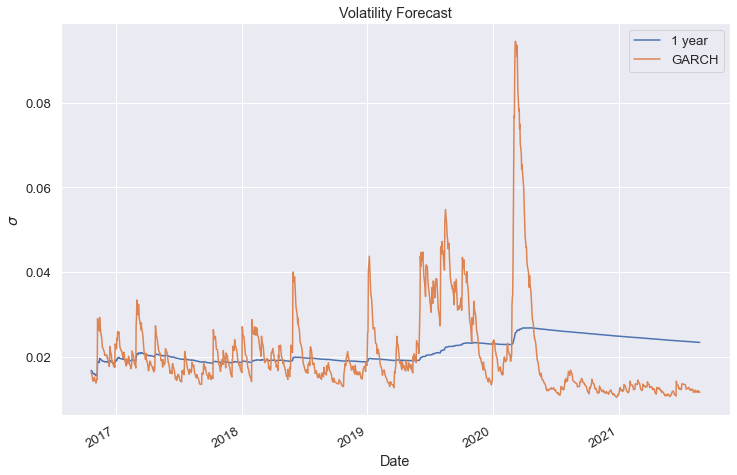

In [12]:
(var**.5).plot()

plt.ylabel(r'$\sigma$')
plt.title('Volatility Forecast')
plt.show()

###### 4.

Given by how much the expanding volatility prediction jumps over the course of 2020, we expect high volatility in the bond markets for the first part of 2020. The subsequent consistent decrease of the expanding prediction suggests much lower volatility in latter part of 2020 and all of 2021. The GARCH prediction suggests the same scenario. GARCH volatility predictions are high for the first part of 2020 and then very low in the later stages of 2020 and in 2021.

We can be confident GARCH performed much better, as it will excel in time periods where volatility clusters. In the first half of 2020 we have high volatility for an extended period of time, and then from the second half of 2020 onwards we have seen low volatility. As GARCH adjusts predictions based on recent vol, it will predict significantly more accurate in time periods such as this.

We expect these movements not just in the treasury bond markets but also in the bond market as a whole to some degree, due to the fact that part of the yields of many bonds can be attributed to a risk free return (the treasury yield).

## 4 OLS vs. LASSO


1. Run the following OLS regression for all data points and report the $R^2$. Let us exclude $y^{1yr}_{t−1}$ as a factor to better examine how OLS and LASSO regression models behave.


$$
y^{1yr}_t = \alpha + y^{2yr}_{t−1} + y^{5yr}_{t−1} + y^{10yr}_{t−1} + y^{30yr}_{t−1}
$$


2. Why might this $R^2$ be misleading when assessing our ability to forecast the 1 year treasury yield?


3. Run LASSO regression for the same regressand and regressors with a parameter of 0.05. Report the $\alpha$, $\beta$ and $R^2$.


4. What would you expect the non-diagonal entries of the covariance matrix of the regressors to look like? Do you think it makes more sense to use the OLS or LASSO model here?

###### 1.

In [13]:
### Make a regression function that outputs parameters and r-squared
def reg(x, y, intercept):
    if intercept == True:
        x = sm.add_constant(x)
    
    run_reg = sm.OLS(y,x).fit()
    
    output_df = run_reg.params.to_frame('Parameters')
    output_df.loc[r'$R^{2}$'] = run_reg.rsquared
    
    return output_df

In [14]:
### Shift our regressors
x = df[df.columns[1:]].shift(1).dropna()

### Make the dataframes the same size so we can use the regression package
y = df['1 year'].iloc[1:].to_frame('1 year').dropna()

reg(x, y, True)

,Parameters
const,-0.185808
2 year,1.705989
5 year,-1.156961
10 year,0.312720
30 year,0.163609
$R^{2}$,0.994519


###### 2.

Treasury yields are not stationary processes. The level of a treasury yield tomorrow is highly dependent on the treasury yield level today, and the $R^2$ reflects this, not whether we can forecast where the yield moves.

###### 3.

In [15]:
model_lasso = Lasso(alpha=.05).fit(x,y)

lasso_res = pd.DataFrame(data = model_lasso.coef_, index = x.columns, columns = ['Parameters'])

lasso_res.loc['Intercept'] = model_lasso.intercept_

round(lasso_res, 3)

,Parameters
2 year,0.927
5 year,0.000
10 year,0.000
30 year,-0.000
Intercept,0.003


In [16]:
print('Lasso r-squared: ' + str(round(model_lasso.score(x,y),3)))

Lasso r-squared: 0.975


###### 4.

Treasury yields of different tenors are highly correlated, so we have non-zero values in the non-diagonal entries of the covariance matrix. We can suspect this by the magnitude of the regressors and $R^2$ in the OLS model vs. the LASSO model, and also by what the securities themselves are (e.g. part of the 2 year treasury yield is based off of what the 1 year yield is).

It makes sense to use LASSO here, as it deals with the multicollinearity exhibited by the OLS regression. The OLS assumption of independent regressors fails in this case.